In [1]:
from Preprocessing.dataloader import *
from torch.utils.data import DataLoader

speed_volume_perturb=False
spec_augment=False
sr = 16000
audio_config = dict(sample_rate=sr,
                          window_size=.02,
                          window_stride=0.01,
                          window='hamming',
                          noise_dir=None,
                          noise_prob=0.4,
                          noise_levels=(0.0, 0.5))
directory = './Data/Hip-Hop/'
out_dir = './Output'
pos_dir = './Data/spectrogram_pos'
neg_dir = None

# save npy files 
if not path.exists(pos_dir):
    os.mkdir(pos_dir)
    if path.exists(out_dir):
        ! rm -r $out_dir
    os.mkdir(out_dir)
    sp = SpectrogramParser(audio_config)
    index = 0
    for file in listdir(directory):
        filepath = path.join(directory, file)
        for i in range(5):
            spect,time = sp.parse_audio(filepath)
            name, wav = file.split('.')
            outfile = path.join(out_dir,name+'_{:.2f}'.format(time)+'.'+wav)
            sp.spectrum2wav(spect, sr, outfile)
            specfile = path.join(pos_dir, str(index)+'_'+name+'_{:.2f}'.format(time))
            np.save(specfile,spect)
            index +=1
    # 16000 465984

train_dataset = SpectrogramDataset(audio_conf=audio_config,
                                   pos_dir=pos_dir,
                                   neg_dir=neg_dir,
                                   normalize=False,
                                   speed_volume_perturb=speed_volume_perturb,
                                   spec_augment=spec_augment)
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)



In [38]:
import matplotlib.pyplot as plt
import librosa.display
def contextTraining(out_target, input_variable, input_sizes, rEncoder, epochs, criterion,optimizer):
    rEncoder.eval()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out_variable = rEncoder(input_variable, input_sizes)
        #print(input_variable[0][0][0][:5])
        loss = criterion(out_variable, out_target)
        loss = loss / input_target.size(0)  # average the loss by minibatch
        loss_value = loss.item()
        if epoch %100 ==0:
            print("epoch:{}".format(epoch),loss_value)
        loss.backward()
        optimizer.step()
    return input_variable

def visualization_spectrogram(mel_spectrogram, title):
    """visualizing result of SpecAugment
    # Arguments:
      mel_spectrogram(ndarray): mel_spectrogram to visualize.
      title(String): plot figure's title
    """
    # Show mel-spectrogram using librosa's specshow.
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram[0, :, :], ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    # plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
def load_model(path):
    print("Loading state from model %s" % path)
    package = torch.load(path, map_location=lambda storage, loc: storage)
    model = DeepSpeech(audio_conf=package['audio_conf'])
    model.load_state_dict(package['state_dict'], strict=False)
    return model

In [39]:
from RecognitionEncoder import DeepSpeech
from torch.autograd import Variable
import torch
from torch.nn import MSELoss
from torch.optim import Adam


# load model parameters
device = torch.device("cuda")
rEncoder = load_model('../deepspeech/librispeech_pretrained_v2.pth')
rEncoder = rEncoder.to(device)
for name, param in rEncoder.named_parameters():
    param.requires_grad=False
    
rEncoder_target = load_model('../deepspeech/librispeech_pretrained_v2.pth')
rEncoder_target = rEncoder_target.to(device)
print(rEncoder.audio_conf)

# TODO hyperparameters
minibatch_size = 1
freq_size = train_dataset.sample_size[0]
max_seqlength = train_dataset.sample_size[1]
lengths = max_seqlength
input_sizes = torch.LongTensor([lengths]*minibatch_size)

criterion = MSELoss()

for i, (data) in enumerate(dataloader):
    pos_sample, neg_sample = data
    # 1, 161, 1001
    input_target = torch.Tensor(pos_sample).unsqueeze(0).to(device)
    input_variable = Variable(torch.randn(input_target.shape).cuda(),requires_grad=True)
    optimizer = Adam([input_variable],lr=0.005)
    
    out_target = Variable(rEncoder_target(input_target, input_sizes))
    trained_variable = contextTraining(out_target, input_variable, input_sizes, rEncoder, 3000, criterion, optimizer)
    
    break

Loading state from model ../deepspeech/librispeech_pretrained_v2.pth
Loading state from model ../deepspeech/librispeech_pretrained_v2.pth
{'sample_rate': 16000, 'window_size': 0.02, 'window_stride': 0.01, 'window': 'hamming', 'noise_dir': None, 'noise_prob': 0.4, 'noise_levels': (0.0, 0.5)}
epoch:0 0.3507654070854187
epoch:100 0.1718067228794098
epoch:200 0.13661278784275055
epoch:300 0.11140590906143188
epoch:400 0.09301117807626724
epoch:500 0.07933991402387619
epoch:600 0.06897704303264618
epoch:700 0.061148714274168015
epoch:800 0.05517242103815079
epoch:900 0.0504080094397068
epoch:1000 0.04639748856425285
epoch:1100 0.043073028326034546
epoch:1200 0.0402270182967186
epoch:1300 0.03784031420946121
epoch:1400 0.035741209983825684
epoch:1500 0.03383593633770943
epoch:1600 0.03215853497385979
epoch:1700 0.03067070059478283
epoch:1800 0.029313020408153534
epoch:1900 0.028081871569156647
epoch:2000 0.026899900287389755
epoch:2100 0.025850731879472733
epoch:2200 0.02494722045958042
epoc

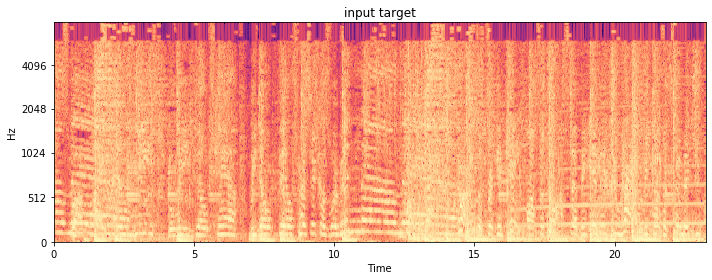

In [27]:
visualization_spectrogram(input_target[0].cpu(),'input target')

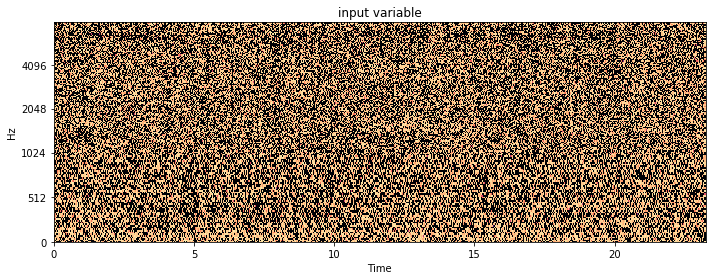

In [29]:
visualization_spectrogram(input_variable[0].cpu().detach(),'input variable')

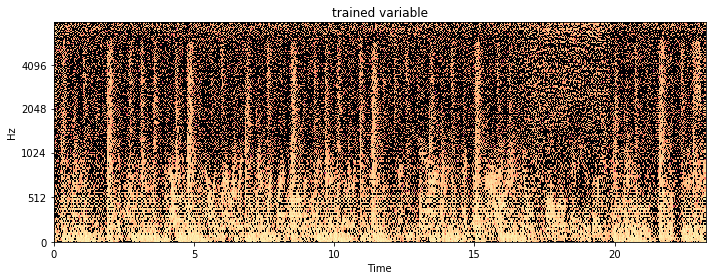

In [40]:
visualization_spectrogram(trained_variable[0].cpu().detach(),'trained variable')